In [1]:
import os
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torch
from torchvision import transforms
from tqdm import tqdm
import torch
from torchvision import transforms
import pandas as pd
import os
from PIL import Image
import random


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, ConcatDataset
from torchvision import transforms, datasets, models
import urllib.request
import tarfile
import os
import pandas as pd
from PIL import Image, ImageFilter
from tqdm import tqdm

import os
import urllib.request
import threading

# 다운로드 받을 경로 설정 (예: 현재 디렉터리 또는 지정된 경로)
download_path = 'DATA'  # 원하는 경로로 변경 가능

# 다운로드 경로가 존재하지 않으면 생성
if not os.path.exists(download_path):
    os.makedirs(download_path)

# 파일 URL 리스트
links = [
    'https://nihcc.box.com/shared/static/vfk49d74nhbxq3nqjg0900w5nvkorp5c.gz',
    'https://nihcc.box.com/shared/static/i28rlmbvmfjbl8p2n3ril0pptcmcu9d1.gz',
    'https://nihcc.box.com/shared/static/f1t00wrtdk94satdfb9olcolqx20z2jp.gz',
    'https://nihcc.box.com/shared/static/0aowwzs5lhjrceb3qp67ahp0rd1l1etg.gz',
    'https://nihcc.box.com/shared/static/v5e3goj22zr6h8tzualxfsqlqaygfbsn.gz',
    'https://nihcc.box.com/shared/static/asi7ikud9jwnkrnkj99jnpfkjdes7l6l.gz',
    'https://nihcc.box.com/shared/static/jn1b4mw4n6lnh74ovmcjb8y48h8xj07n.gz',
    'https://nihcc.box.com/shared/static/tvpxmn7qyrgl0w8wfh9kqfjskv6nmm1j.gz',
    'https://nihcc.box.com/shared/static/upyy3ml7qdumlgk2rfcvlb9k6gvqq2pj.gz',
    'https://nihcc.box.com/shared/static/l6nilvfa9cg3s28tqv1qc1olm3gnz54p.gz',
    'https://nihcc.box.com/shared/static/hhq8fkdgvcari67vfhs7ppg2w6ni4jze.gz',
    'https://nihcc.box.com/shared/static/ioqwiy20ihqwyr8pf4c24eazhh281pbu.gz'
]

# 파일 다운로드 함수
def download_file(url, download_dir, idx):
    fn = os.path.join(download_dir, f'images_{idx+1:02d}.tar.gz')
    print(f'Downloading {fn}...')
    urllib.request.urlretrieve(url, fn)  # 파일 다운로드
    print(f'{fn} download complete.')

# 다운로드 스레드 생성
threads = []
for idx, link in enumerate(links):
    thread = threading.Thread(target=download_file, args=(link, download_path, idx))
    threads.append(thread)
    thread.start()

# 모든 스레드가 끝날 때까지 기다리기
for thread in threads:
    thread.join()

print("All downloads complete. Files are saved in", download_path)

import os
import tarfile
import shutil

# tar 파일들이 저장된 경로 (다운로드 경로와 동일하게 설정)
tar_dir = 'DATA'  # 원본 tar 파일들이 저장된 경로
extract_dir = 'DATA'  # 압축 해제할 경로

# Loop through each downloaded tar file and extract it
for idx in range(1, len(links) + 1):
    tar_path = os.path.join(tar_dir, f'images_{idx:02d}.tar.gz')

    # Extract the tar file into the specified directory
    print(f'Extracting {tar_path} to {extract_dir}...')
    with tarfile.open(tar_path, 'r:gz') as tar:
        tar.extractall(path=extract_dir)

    # Delete the original tar.gz file after extraction
    os.remove(tar_path)
    print(f'Deleted {tar_path} after extraction.')

print("Extraction complete.")



DATA/images_01.tar.gz download complete.
DATA/images_12.tar.gz download complete.
DATA/images_04.tar.gz download complete.
DATA/images_03.tar.gz download complete.
DATA/images_05.tar.gz download complete.
DATA/images_06.tar.gz download complete.
DATA/images_09.tar.gz download complete.
DATA/images_11.tar.gz download complete.
DATA/images_07.tar.gz download complete.
DATA/images_08.tar.gz download complete.
DATA/images_02.tar.gz download complete.
DATA/images_10.tar.gz download complete.
All downloads complete. Files are saved in DATA
Extracting DATA/images_01.tar.gz to DATA...
Deleted DATA/images_01.tar.gz after extraction.
Extracting DATA/images_02.tar.gz to DATA...
Deleted DATA/images_02.tar.gz after extraction.
Extracting DATA/images_03.tar.gz to DATA...
Deleted DATA/images_03.tar.gz after extraction.
Extracting DATA/images_04.tar.gz to DATA...
Deleted DATA/images_04.tar.gz after extraction.
Extracting DATA/images_05.tar.gz to DATA...
Deleted DATA/images_05.tar.gz after extraction.


In [12]:
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
import random
import os
from torchvision import transforms
from PIL import Image
import torch
from sklearn.model_selection import StratifiedShuffleSplit, GroupShuffleSplit
import pandas as pd


csv_file_path = './Data_Entry_2017_v2020.csv'

df = pd.read_csv(csv_file_path)

class_names = ['Atelectasis',  'Consolidation',  'Effusion',
                 'Infiltration', 'Mass', 'Nodule', 'Pneumothorax'
                #'Pleural_Thickening',
               #'Hernia',
               # 'Pneumonia',
               # 'Fibrosis',
               #  'Edema',
               # 'Cardiomegaly',
               # 'Emphysema',
            ]

def get_labels(diseases):
    labels = torch.zeros(len(class_names))
    if diseases != 'No Finding':
        for label_name in diseases.split('|'):
            if label_name in class_names:
                labels[class_names.index(label_name)] = 1
    return labels

class CXR14dataset(Dataset):
    def __init__(self, img_dirs, df, augment=None):
        self.img_dirs = img_dirs
        self.df = df
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize([0.5123], [0.2307])
        ])
        self.augment = augment

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_name = self.df.iloc[idx, 0]
        diseases = self.df.iloc[idx, 1]
        label = get_labels(diseases)

        image = None
        for img_dir in self.img_dirs:
            img_path = os.path.join(img_dir, img_name)
            if os.path.exists(img_path):
                image = Image.open(img_path).convert("RGB")
                break

        if image is None:
            raise FileNotFoundError(f"Image {img_name} not found in provided directories.")

        if self.augment:
            image = self.augment(image)
        else:
            image = self.transform(image)

        return image, label

img_dirs = ['./DATA/images']

# 데이터셋을 train, validation, test로 나누기 (Stratified Split을 사용하여 클래스 비율 유지)
# 모든 질병 컬럼을 하나의 벡터로 결합하여 분할 (멀티 라벨 문제에 대한 처리)
df['combined_labels'] = df['Finding Labels'].apply(
    lambda x: '|'.join(sorted([label for label in x.split('|') if label in class_names]))
)

sampling_ratios = {
    'Atelectasis': 1,
    'Cardiomegaly': 1,
    'Consolidation': 1,
    #'Edema': 1,
    'Effusion': 1,
    'Emphysema': 1,
    #'Fibrosis': 1,
    #'Hernia': 1,
    'Infiltration': 1,
    'Mass': 1,
    'Nodule': 1,
    #'Pneumonia': 1,
    'Pleural_Thickening': 1,
    'Pneumothorax': 1,
    'No Finding': 0.6
}

def apply_class_sampling(df, class_names, sampling_ratios):
    sampled_df = pd.DataFrame()
    for class_name in class_names:
        if class_name == 'No Finding':
            no_finding_df = df[df['Finding Labels'] == 'No Finding']
            sample_size = int(len(no_finding_df) * sampling_ratios[class_name])
            sampled_no_finding_df = no_finding_df.sample(n=sample_size, random_state=42)
            sampled_df = pd.concat([sampled_df, sampled_no_finding_df], axis=0)
        else:
            class_df = df[df['Finding Labels'].str.contains(class_name)]
            sample_size = int(len(class_df) * sampling_ratios[class_name])
            sampled_class_df = class_df.sample(n=sample_size, random_state=42)
            sampled_df = pd.concat([sampled_df, sampled_class_df], axis=0)
    return sampled_df

class_names_nf = class_names + ['No Finding']
print(class_names)

df_sampled = apply_class_sampling(df, class_names_nf, sampling_ratios)

class_counts = df_sampled['combined_labels'].value_counts()

rare_classes = class_counts[class_counts < 10].index

df_filtered = df_sampled[~df_sampled['combined_labels'].isin(rare_classes)]

# train_df, temp_df = train_test_split(df_filtered, test_size=0.2, stratify=df_filtered['combined_labels'], random_state=42)
# valid_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['combined_labels'], random_state=42)


group_split = GroupShuffleSplit(test_size=0.2, n_splits=1, random_state=42)
train_indices, temp_indices = next(group_split.split(df_filtered, groups=df_filtered['Patient ID']))
train_df = df_filtered.iloc[train_indices]
temp_df = df_filtered.iloc[temp_indices]

stratified_split = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=42)

for valid_indices, test_indices in stratified_split.split(temp_df, temp_df['combined_labels']):
    valid_df = temp_df.iloc[valid_indices]
    test_df = temp_df.iloc[test_indices]

print(f"Train data: {train_df.shape}")
print(f"Validation data: {valid_df.shape}")
print(f"Test data: {test_df.shape}")


batch_size = 64
num_cores = os.cpu_count()
train_dataset = CXR14dataset(img_dirs=img_dirs, df=train_df)
valid_dataset = CXR14dataset(img_dirs=img_dirs, df=valid_df)
test_dataset = CXR14dataset(img_dirs=img_dirs, df=test_df)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_cores, pin_memory=True, persistent_workers=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=num_cores, pin_memory=True, persistent_workers=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_cores, pin_memory=True, persistent_workers=True)


for images, labels in train_loader:
    print(images.shape)
    print(labels.shape)
    break


['Atelectasis', 'Consolidation', 'Effusion', 'Infiltration', 'Mass', 'Nodule', 'Pneumothorax']
Train data: (82104, 12)
Validation data: (10450, 12)
Test data: (10451, 12)
torch.Size([64, 3, 224, 224])
torch.Size([64, 7])


<ipython-input-13-0160daea15a3>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=train_class_counts.index, y=train_class_counts.values/train_class_counts.sum(), palette='viridis', ax=axes[0])
<ipython-input-13-0160daea15a3>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=valid_class_counts.index, y=valid_class_counts.values/valid_class_counts.sum(), palette='viridis', ax=axes[1])
<ipython-input-13-0160daea15a3>:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=test_class_counts.index, y=test_class_counts.values/test_class_counts.sum

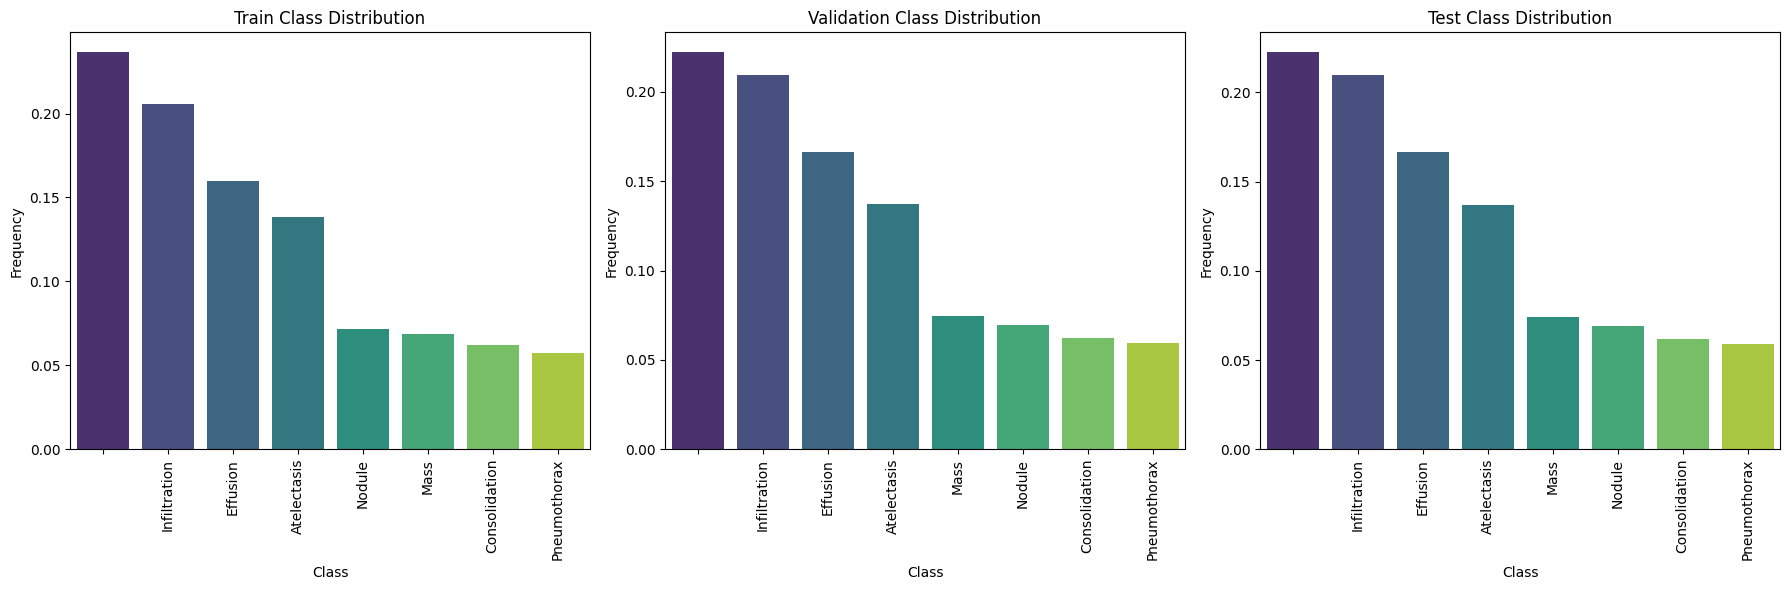

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

train_class_counts = train_df['combined_labels'].str.split('|', expand=True).stack().value_counts()
valid_class_counts = valid_df['combined_labels'].str.split('|', expand=True).stack().value_counts()
test_class_counts = test_df['combined_labels'].str.split('|', expand=True).stack().value_counts()

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

sns.barplot(x=train_class_counts.index, y=train_class_counts.values/train_class_counts.sum(), palette='viridis', ax=axes[0])
axes[0].set_title('Train Class Distribution')
axes[0].set_xlabel('Class')
axes[0].set_ylabel('Frequency')
axes[0].tick_params(axis='x', rotation=90)

sns.barplot(x=valid_class_counts.index, y=valid_class_counts.values/valid_class_counts.sum(), palette='viridis', ax=axes[1])
axes[1].set_title('Validation Class Distribution')
axes[1].set_xlabel('Class')
axes[1].set_ylabel('Frequency')
axes[1].tick_params(axis='x', rotation=90)

sns.barplot(x=test_class_counts.index, y=test_class_counts.values/test_class_counts.sum(), palette='viridis', ax=axes[2])
axes[2].set_title('Test Class Distribution')
axes[2].set_xlabel('Class')
axes[2].set_ylabel('Frequency')
axes[2].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()


In [14]:
import torch
import torch.nn as nn
from torchvision.models import resnet18
from torchsummary import summary

class CustomResNet18(nn.Module):
    def __init__(self, num_classes):
        super(CustomResNet18, self).__init__()

        resnet = resnet18(weights="IMAGENET1K_V1")  # Always use pretrained weights
        self.conv1 = resnet.conv1
        self.bn1 = resnet.bn1
        self.relu = resnet.relu
        self.maxpool = resnet.maxpool
        self.layer1 = resnet.layer1
        self.layer2 = resnet.layer2
        self.layer3 = resnet.layer3
        self.layer4 = resnet.layer4
        self.avgpool = resnet.avgpool

        self.dropout1 = nn.Dropout(p=0.3)
        self.dropout2 = nn.Dropout(p=0.4)
        self.dropout3 = nn.Dropout(p=0.4)
        self.dropout4 = nn.Dropout(p=0.5)

        self.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.dropout1(x)

        x = self.layer2(x)
        x = self.dropout2(x)

        x = self.layer3(x)
        x = self.dropout3(x)

        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.dropout4(x)
        x = self.fc(x)
        return x


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = len(class_names)
model = CustomResNet18(num_classes=num_classes).to(device)

input_size = (3, 224, 224)
summary(model, input_size=input_size, device=device.type)



----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [15]:
import torch.optim as optim
import torch.nn as nn
import torch.optim.lr_scheduler as lr_scheduler


class_weights=train_class_counts.sum()/train_class_counts
class_weights=class_weights/(class_weights[0])
class_weights=torch.tensor(class_weights)
class_weights = class_weights[1:]
print(class_weights)


criterion = nn.BCEWithLogitsLoss()
# criterion = nn.BCEWithLogitsLoss(pos_weight=class_weights)
criterion = criterion.to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-3)

scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)


tensor([1.1503, 1.4783, 1.7108, 3.3112, 3.4423, 3.8177, 4.1254],
       dtype=torch.float64)


<ipython-input-15-12598d2d397e>:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  class_weights=class_weights/(class_weights[0])
<ipython-input-15-12598d2d397e>:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  class_weights=torch.tensor(class_weights)


In [16]:
from tqdm import tqdm
from sklearn.metrics import f1_score

num_epochs = 20
best_valid_f1 = 0.0
save_path = "./resnet.pth"

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_preds = 0
    total_preds = 0

    # Training loop
    for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch"):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        preds = (torch.sigmoid(outputs) > 0.5).float()
        correct_preds += (preds == labels).all(dim=1).sum().item()
        total_preds += preds.size(0)

    train_loss = running_loss / len(train_loader)
    train_accuracy = correct_preds / total_preds

    model.eval()
    valid_loss = 0.0
    correct_preds = 0
    total_preds = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in tqdm(valid_loader, desc=f"Validating Epoch {epoch+1}/{num_epochs}", unit="batch"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            valid_loss += loss.item()

            preds = (torch.sigmoid(outputs) > 0.5).float()
            correct_preds += (preds == labels).all(dim=1).sum().item()
            total_preds += preds.size(0)

            all_preds.append(preds.cpu())
            all_labels.append(labels.cpu())

        valid_loss = valid_loss / len(valid_loader)
        valid_accuracy = correct_preds / total_preds

        all_preds = torch.cat(all_preds).numpy()
        all_labels = torch.cat(all_labels).numpy()
        f1 = f1_score(all_labels, all_preds, average='macro')

        if f1 > best_valid_f1:
            best_valid_f1 = f1
            torch.save(model.state_dict(), save_path)
            print(f"Best model saved with F1: {f1:.4f}")

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")
    print(f"Valid Loss: {valid_loss:.4f}, Valid Accuracy: {valid_accuracy:.4f}")
    print(f"Validation F1 Score: {f1:.4f}")

from sklearn.metrics import classification_report

from sklearn.metrics import f1_score, roc_auc_score
import numpy as np

# --- Test Loop ---
model.load_state_dict(torch.load(save_path))
model.eval()
test_loss = 0.0
correct_preds = 0
total_preds = 0
all_preds = []
all_labels = []
all_probs = []

class_correct = [0] * num_classes
class_total = [0] * num_classes

with torch.no_grad():
    for inputs, labels in tqdm(test_loader, desc="Testing", unit="batch"):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        preds = (torch.sigmoid(outputs) > 0.5).float()
        correct_preds += (preds == labels).all(dim=1).sum().item()
        total_preds += preds.size(0)

        all_preds.append(preds.cpu())
        all_labels.append(labels.cpu())

        all_probs.append(torch.sigmoid(outputs).cpu())

        for i in range(num_classes):
            class_correct[i] += ((preds[:, i] == labels[:, i]).sum()).item()
            class_total[i] += labels[:, i].size(0)

test_loss = test_loss / len(test_loader)
test_accuracy = correct_preds / total_preds

all_preds = torch.cat(all_preds).numpy()
all_labels = torch.cat(all_labels).numpy()
test_f1 = f1_score(all_labels, all_preds, average='macro')  # Macro-Averaged F1 Score

all_probs = torch.cat(all_probs).numpy()
auc = roc_auc_score(all_labels, all_probs, average='macro', multi_class='ovr')  # Multi-class AUC (One-vs-Rest)

class_accuracy = [class_correct[i] / class_total[i] if class_total[i] > 0 else 0 for i in range(num_classes)]

report = classification_report(all_labels, all_preds, target_names=class_names, zero_division=0)

print("\nTest Results")
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")
print(f"Test F1 Score: {test_f1:.4f}")
print(f"Test AUC Score: {auc:.4f}")

print("\nClass-wise Accuracy:")
for i, accuracy in enumerate(class_accuracy):
    print(f"Class {class_names[i]}: {accuracy:.4f}")

print("\nClassification Report:")
print(report)


Validating Epoch 1/20: 100%|██████████| 164/164 [00:31<00:00,  5.14batch/s]


Best model saved with F1: 0.2292
Epoch 1/20
Train Loss: 0.3750, Train Accuracy: 0.3591
Valid Loss: 0.3770, Valid Accuracy: 0.3463
Validation F1 Score: 0.2292


Validating Epoch 2/20: 100%|██████████| 164/164 [00:31<00:00,  5.17batch/s]


Epoch 2/20
Train Loss: 0.3541, Train Accuracy: 0.3702
Valid Loss: 0.3797, Valid Accuracy: 0.3448
Validation F1 Score: 0.2108


Validating Epoch 3/20: 100%|██████████| 164/164 [00:31<00:00,  5.25batch/s]


Best model saved with F1: 0.2689
Epoch 3/20
Train Loss: 0.3429, Train Accuracy: 0.3775
Valid Loss: 0.3704, Valid Accuracy: 0.3611
Validation F1 Score: 0.2689


Validating Epoch 4/20: 100%|██████████| 164/164 [00:31<00:00,  5.24batch/s]


Best model saved with F1: 0.2960
Epoch 4/20
Train Loss: 0.3299, Train Accuracy: 0.3830
Valid Loss: 0.3685, Valid Accuracy: 0.3556
Validation F1 Score: 0.2960


Validating Epoch 5/20: 100%|██████████| 164/164 [00:31<00:00,  5.26batch/s]


Epoch 5/20
Train Loss: 0.3143, Train Accuracy: 0.3923
Valid Loss: 0.3821, Valid Accuracy: 0.3599
Validation F1 Score: 0.2716


Validating Epoch 6/20: 100%|██████████| 164/164 [00:31<00:00,  5.22batch/s]


Epoch 6/20
Train Loss: 0.2927, Train Accuracy: 0.4128
Valid Loss: 0.3946, Valid Accuracy: 0.3574
Validation F1 Score: 0.2928


Validating Epoch 7/20: 100%|██████████| 164/164 [00:31<00:00,  5.20batch/s]


Epoch 7/20
Train Loss: 0.2659, Train Accuracy: 0.4444
Valid Loss: 0.4365, Valid Accuracy: 0.3431
Validation F1 Score: 0.2925


Validating Epoch 8/20: 100%|██████████| 164/164 [00:31<00:00,  5.23batch/s]


Best model saved with F1: 0.3183
Epoch 8/20
Train Loss: 0.2352, Train Accuracy: 0.4926
Valid Loss: 0.4579, Valid Accuracy: 0.3378
Validation F1 Score: 0.3183


Validating Epoch 9/20: 100%|██████████| 164/164 [00:31<00:00,  5.19batch/s]


Epoch 9/20
Train Loss: 0.2037, Train Accuracy: 0.5422
Valid Loss: 0.5068, Valid Accuracy: 0.3427
Validation F1 Score: 0.3019


Validating Epoch 10/20: 100%|██████████| 164/164 [00:31<00:00,  5.24batch/s]


Epoch 10/20
Train Loss: 0.1774, Train Accuracy: 0.5913
Valid Loss: 0.5313, Valid Accuracy: 0.3295
Validation F1 Score: 0.3048


Validating Epoch 11/20: 100%|██████████| 164/164 [00:31<00:00,  5.24batch/s]


Best model saved with F1: 0.3232
Epoch 11/20
Train Loss: 0.1541, Train Accuracy: 0.6349
Valid Loss: 0.5714, Valid Accuracy: 0.3211
Validation F1 Score: 0.3232


Validating Epoch 12/20: 100%|██████████| 164/164 [00:31<00:00,  5.25batch/s]


Epoch 12/20
Train Loss: 0.1347, Train Accuracy: 0.6745
Valid Loss: 0.6202, Valid Accuracy: 0.3272
Validation F1 Score: 0.3171


Validating Epoch 13/20: 100%|██████████| 164/164 [00:31<00:00,  5.27batch/s]


Epoch 13/20
Train Loss: 0.1203, Train Accuracy: 0.7051
Valid Loss: 0.6786, Valid Accuracy: 0.3307
Validation F1 Score: 0.2826


Validating Epoch 14/20: 100%|██████████| 164/164 [00:31<00:00,  5.24batch/s]


Epoch 14/20
Train Loss: 0.1066, Train Accuracy: 0.7377
Valid Loss: 0.7249, Valid Accuracy: 0.3319
Validation F1 Score: 0.2690


Validating Epoch 15/20: 100%|██████████| 164/164 [00:31<00:00,  5.20batch/s]


Epoch 15/20
Train Loss: 0.0953, Train Accuracy: 0.7606
Valid Loss: 0.7699, Valid Accuracy: 0.3258
Validation F1 Score: 0.3015


Validating Epoch 16/20: 100%|██████████| 164/164 [00:31<00:00,  5.22batch/s]


Epoch 16/20
Train Loss: 0.0867, Train Accuracy: 0.7830
Valid Loss: 0.8384, Valid Accuracy: 0.3195
Validation F1 Score: 0.2838


Validating Epoch 17/20: 100%|██████████| 164/164 [00:31<00:00,  5.16batch/s]


Epoch 17/20
Train Loss: 0.0781, Train Accuracy: 0.8042
Valid Loss: 0.8659, Valid Accuracy: 0.3219
Validation F1 Score: 0.2848


Validating Epoch 18/20: 100%|██████████| 164/164 [00:31<00:00,  5.25batch/s]


Epoch 18/20
Train Loss: 0.0716, Train Accuracy: 0.8189
Valid Loss: 0.8892, Valid Accuracy: 0.3129
Validation F1 Score: 0.3065


Validating Epoch 19/20: 100%|██████████| 164/164 [00:31<00:00,  5.21batch/s]


Epoch 19/20
Train Loss: 0.0660, Train Accuracy: 0.8346
Valid Loss: 0.8971, Valid Accuracy: 0.3022
Validation F1 Score: 0.3065


Validating Epoch 20/20: 100%|██████████| 164/164 [00:31<00:00,  5.21batch/s]
<ipython-input-16-dd1f3cf98bfb>:75: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_sta

Epoch 20/20
Train Loss: 0.0612, Train Accuracy: 0.8458
Valid Loss: 0.9375, Valid Accuracy: 0.3183
Validation F1 Score: 0.2851


Testing: 100%|██████████| 164/164 [00:32<00:00,  5.12batch/s]


Test Results
Test Loss: 0.5728, Test Accuracy: 0.3135
Test F1 Score: 0.3204
Test AUC Score: 0.7069

Class-wise Accuracy:
Class Atelectasis: 0.7598
Class Consolidation: 0.8948
Class Effusion: 0.7949
Class Infiltration: 0.6628
Class Mass: 0.8824
Class Nodule: 0.8888
Class Pneumothorax: 0.9103

Classification Report:
               precision    recall  f1-score   support

  Atelectasis       0.42      0.41      0.41      2184
Consolidation       0.25      0.06      0.10       987
     Effusion       0.59      0.62      0.60      2651
 Infiltration       0.47      0.42      0.44      3339
         Mass       0.47      0.28      0.35      1182
       Nodule       0.37      0.08      0.13      1102
 Pneumothorax       0.51      0.13      0.21       944

    micro avg       0.49      0.36      0.42     12389
    macro avg       0.44      0.28      0.32     12389
 weighted avg       0.46      0.36      0.39     12389
  samples avg       0.27      0.24      0.23     12389



In [17]:
# --- Test Loop ---
model.load_state_dict(torch.load(save_path))  # 저장된 최고 모델 로드
model.eval()  # 평가 모드로 설정
test_loss = 0.0
correct_preds = 0
total_preds = 0
all_preds = []
all_labels = []
all_probs = []  # AUC 계산을 위한 확률 값 저장

# 클래스별 정확도 계산을 위한 변수
class_correct = [0] * num_classes  # 각 클래스별 맞은 예측 수
class_total = [0] * num_classes    # 각 클래스별 전체 예측 수

with torch.no_grad():
    for inputs, labels in tqdm(test_loader, desc="Testing", unit="batch"):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        # 예측값 계산 (sigmoid thresholding)
        preds = (torch.sigmoid(outputs) > 0.5).float()
        correct_preds += (preds == labels).all(dim=1).sum().item()
        total_preds += preds.size(0)

        # F1 Score 계산을 위해 모든 예측과 레이블 저장
        all_preds.append(preds.cpu())
        all_labels.append(labels.cpu())

        # AUC 계산을 위해 확률 값 저장 (sigmoid 출력값 사용)
        all_probs.append(torch.sigmoid(outputs).cpu())

        # 클래스별 정확도 계산
        for i in range(num_classes):
            class_correct[i] += ((preds[:, i] == labels[:, i]).sum()).item()  # 각 클래스별 맞은 예측
            class_total[i] += labels[:, i].size(0)  # 각 클래스별 전체 예측 수

# 평균 손실과 정확도 계산
test_loss = test_loss / len(test_loader)
test_accuracy = correct_preds / total_preds

# F1 Score 계산
all_preds = torch.cat(all_preds).numpy()
all_labels = torch.cat(all_labels).numpy()
test_f1 = f1_score(all_labels, all_preds, average='macro')  # Macro-Averaged F1 Score

# AUC 계산
all_probs = torch.cat(all_probs).numpy()
auc = roc_auc_score(all_labels, all_probs, average='macro', multi_class='ovr')  # Multi-class AUC (One-vs-Rest)

# 클래스별 정확도 계산
class_accuracy = [class_correct[i] / class_total[i] if class_total[i] > 0 else 0 for i in range(num_classes)]

# Classification Report로 클래스별 지표 출력
report = classification_report(all_labels, all_preds, target_names=class_names, zero_division=0)  # `class_names`는 클래스 이름 리스트

# 출력
print("\nTest Results")
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")
print(f"Test F1 Score: {test_f1:.4f}")
print(f"Test AUC Score: {auc:.4f}")  # AUC 출력

# 클래스별 정확도 출력
print("\nClass-wise Accuracy:")
for i, accuracy in enumerate(class_accuracy):
    print(f"Class {class_names[i]}: {accuracy:.4f}")

print("\nClassification Report:")
print(report)

<ipython-input-17-863af0555f13>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(save_path))  # 저장된 최고 모델 로드
Testing: 100%|██████████| 164/1


Test Results
Test Loss: 0.5728, Test Accuracy: 0.3135
Test F1 Score: 0.3204
Test AUC Score: 0.7069

Class-wise Accuracy:
Class Atelectasis: 0.7598
Class Consolidation: 0.8948
Class Effusion: 0.7949
Class Infiltration: 0.6628
Class Mass: 0.8824
Class Nodule: 0.8888
Class Pneumothorax: 0.9103

Classification Report:
               precision    recall  f1-score   support

  Atelectasis       0.42      0.41      0.41      2184
Consolidation       0.25      0.06      0.10       987
     Effusion       0.59      0.62      0.60      2651
 Infiltration       0.47      0.42      0.44      3339
         Mass       0.47      0.28      0.35      1182
       Nodule       0.37      0.08      0.13      1102
 Pneumothorax       0.51      0.13      0.21       944

    micro avg       0.49      0.36      0.42     12389
    macro avg       0.44      0.28      0.32     12389
 weighted avg       0.46      0.36      0.39     12389
  samples avg       0.27      0.24      0.23     12389

